In [15]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

# Preprocessing

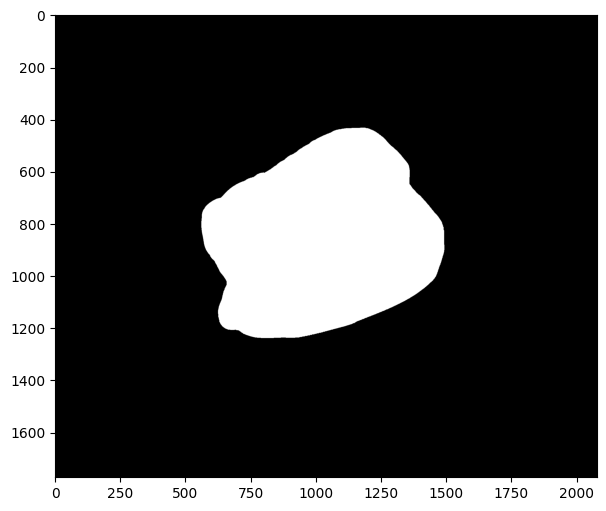

Number of contours detected: 1


In [16]:
IMG = cv.imread('thresh_img/pore1.png', 1)
gray = cv.cvtColor(IMG, cv.COLOR_BGR2GRAY)

# apply thresholding to convert grayscale to binary image
ret,THRESH = cv.threshold(gray,100,255,0)
tresh = 255 - THRESH

def plot(res):
    plt.figure(figsize=(10,6))
    plt.imshow(res, cmap='grey')
    plt.show()
    
plot(THRESH)

# find the contours
contours,hierarchy = cv.findContours(THRESH, cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)
print("Number of contours detected:", len(contours))

# select the first contour
CNT = contours[0]

# Approximate border of pore with ellipse or rectangle
### *Can be used for measuring isometry of the pore*

/var/folders/r_/xvc889350jb1wjh3s9_zfq4m0000gn/T/ipykernel_13672/2245712006.py:9: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


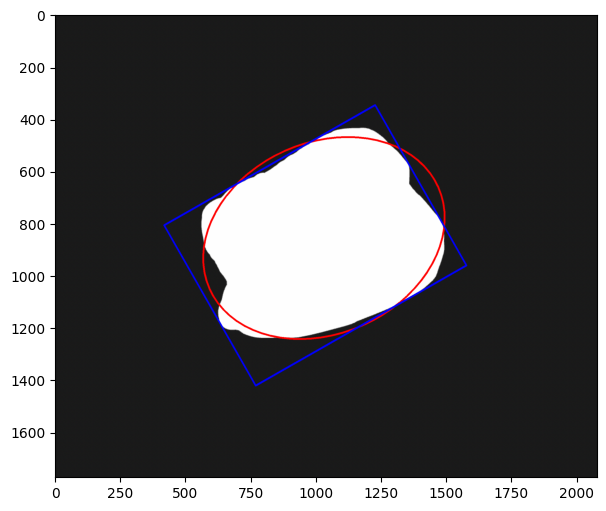

In [17]:
def apply_ell_rect(cnt, img, linew=5):
    # TODO: make separate functions
    # fit the ellipse to the selected object
    ellipse = cv.fitEllipse(cnt)
    
    # find smallest external rectangle
    rect = cv.minAreaRect(cnt)
    box = cv.boxPoints(rect)
    box = np.int0(box)
    
    img = img.copy()
    cv.ellipse(img,ellipse, (255,0,0), linew)
    cv.drawContours(img,[box],0,(0,0,255),linew)
    return img

plot(apply_ell_rect(CNT, IMG))

Number of contours detected: 56


/var/folders/r_/xvc889350jb1wjh3s9_zfq4m0000gn/T/ipykernel_13672/2245712006.py:9: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


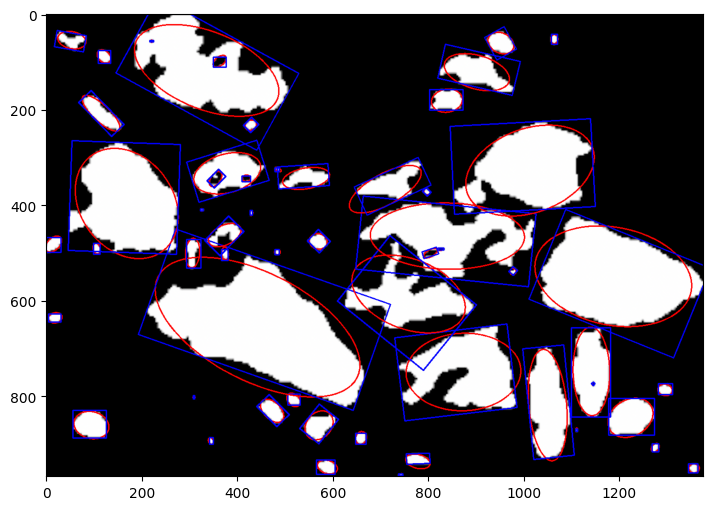

In [18]:
IMG2 = cv.imread('thresh_img/many_pores.png', 1)
gray = cv.cvtColor(IMG2, cv.COLOR_BGR2GRAY)

# apply thresholding to convert grayscale to binary image
ret, thresh = cv.threshold(gray,100,255,0)
tresh = 255 - thresh

# find the contours
contours,hierarchy = cv.findContours(thresh, cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)
print("Number of contours detected:", len(contours))
# TODO: filter secondary and small pores

img = IMG2.copy()
for cnt in contours:
    img = apply_ell_rect(cnt, img, linew=2)

plot(img)

# Find pairs of the closest and the farest points of the pore
### *Can be used for measuring the average size of the pore*

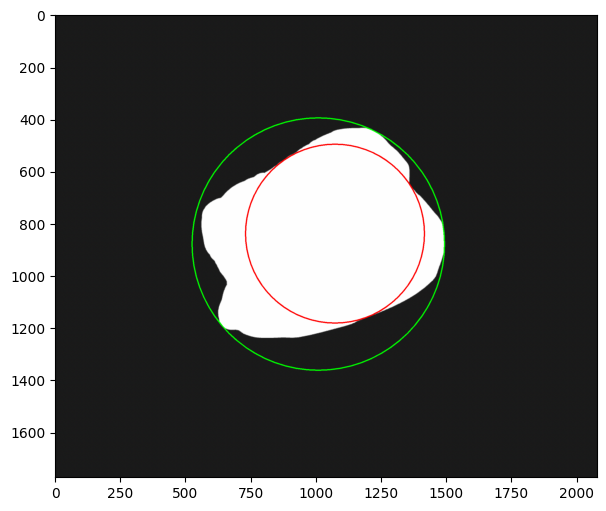

In [19]:
def apply_circ(cnt, img, stat=False, linew=3):
    # TODO: optimize section below
    # Internal Circumference
    temp = np.zeros_like(img)
    temp = cv.cvtColor(temp, cv.COLOR_BGR2GRAY)
    cv.drawContours(temp, cnt, -1, (255, 255, 255), 1)
    cv.fillPoly(temp, pts=[cnt], color=(255,255,255))
    ret, temp = cv.threshold(temp, 100, 255, 0)
    
    
    dist = cv.distanceTransform(temp,
                                cv.DIST_L2, 
                                cv.DIST_MASK_PRECISE) # Perform the distance transform 
    
    
    
    # External Circumference
    (x_axis,y_axis), R = cv.minEnclosingCircle(cnt)

    if stat:
        return np.max(dist), R
    else:
        indices = np.unravel_index(dist.argmax(), dist.shape) # find peak
        r = int(dist[indices])
        center = (int(x_axis),int(y_axis))
        
        img = img.copy()
        cv.circle(img,center,int(R),(0,255,0),linew)
        cv.circle(img, indices[::-1], r, (255,0,0), linew)
        return img

plot(apply_circ(CNT, IMG))

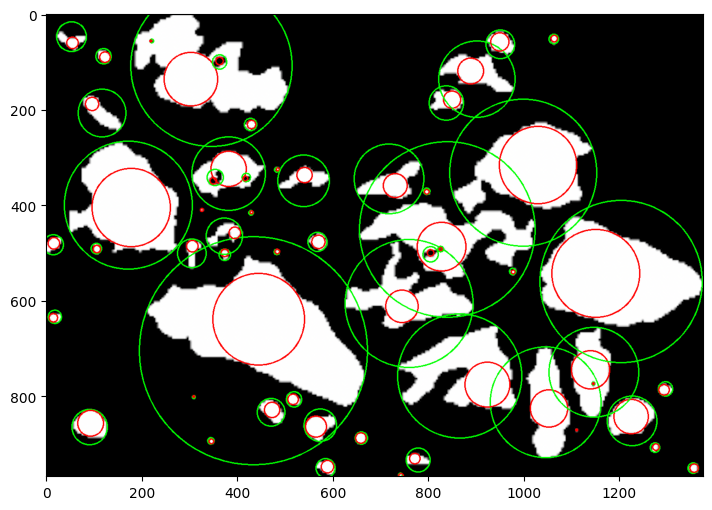

In [20]:
img = IMG2.copy()
for cnt in contours:
    img = apply_circ(cnt, img, linew=2)

plot(img)

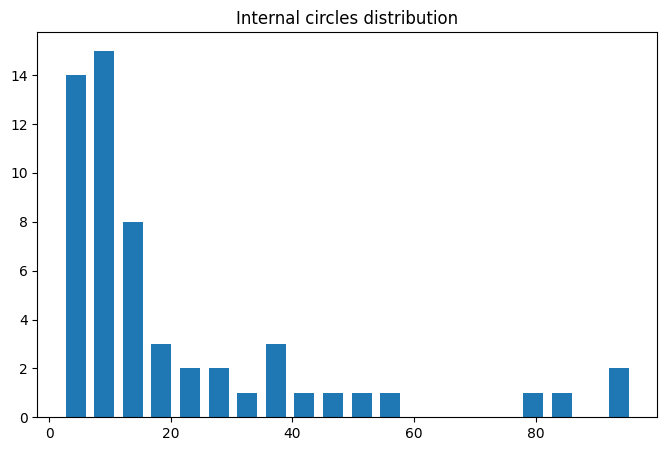

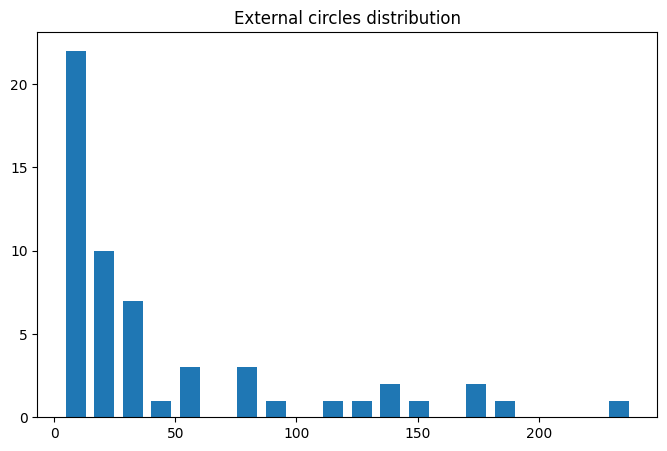

In [27]:
img = IMG2.copy()

R_list = np.array([apply_circ(cnt, img, stat=True) for cnt in contours])

plt.figure(figsize=(8,5))
plt.title('Internal circles distribution')
plt.hist(R_list[:,0], bins=20, rwidth=0.7)
plt.show()

plt.figure(figsize=(8,5))
plt.title('External circles distribution')
plt.hist(R_list[:,1], bins=20, rwidth=0.7)
plt.show()